In [1]:
%%capture
# IMPORTS
import GDI
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.utils import io
import copy

In [2]:
# PARAMETERS

# number of nodes
R  = 11

# number of samples
N  = 1e5  

# memory parameter
M  = 3     

# bootstrap iterations
B = 100

# weights/betas
p1 = 0.5
p2 = 0.75
p3 = 0.5
p4 = 0.5
p5 = 0.75

# Power used for relationship between nodes
P = 2

In [3]:
# GENERATE RAW DATA
# X has dim: NxR
X = np.random.uniform(size=(int(N),int(R)))
Z = np.random.multivariate_normal(np.zeros((R,)),0.25*np.eye(R), int(N))

In [4]:
# IMPLEMENT CAUSALITY/STRUCTURE
# shift things in time to create causal Gaussian network with weights used before
X[1:,0]  = np.sqrt(1-p1)*copy.deepcopy(Z[1:,0])  + np.sqrt(p1)*copy.deepcopy((X[:-1,5]**P))
X[1:,2]  = np.sqrt(1-p1)*copy.deepcopy(Z[1:,2])  + np.sqrt(p1)*copy.deepcopy((X[:-1,5]**P))
X[1:,4]  = np.sqrt(1-p1)*copy.deepcopy(Z[1:,4])  - np.sqrt(p1)*copy.deepcopy((X[:-1,5]**P))
X[1:,3]  = np.sqrt(1-p2)*copy.deepcopy(Z[1:,3])  + np.sqrt(p2)*copy.deepcopy((X[:-1,0]**P))
X[1:,1]  = np.sqrt(1-p3)*copy.deepcopy(Z[1:,1])  - np.sqrt(p3/3)*copy.deepcopy((X[:-1,7]**P)) + np.sqrt(p3/3)*copy.deepcopy((X[:-1,8]**P)) + np.sqrt(p3/3)*copy.deepcopy((X[:-1,5]**P))
X[1:,10] = np.sqrt(1-p4)*copy.deepcopy(Z[1:,10]) + np.sqrt(p4)*copy.deepcopy((X[:-1,3]**P))
X[1:,9]  = np.sqrt(1-p5)*copy.deepcopy(Z[1:, 9]) + np.sqrt(p5/2)*copy.deepcopy((X[:-1,4]**P)) + np.sqrt(p5/2)*copy.deepcopy((X[:-1,2]**P))

In [5]:
# TRUE CONNECTIVITY
true_connectivity = np.zeros((R,R))
true_connectivity[5,[0, 2, 4,]] = np.asarray([p1, p1, -p1,])
true_connectivity[[5, 8,],1] = p3/3
true_connectivity[7,1] = -p3/3
true_connectivity[[2, 4],9] = p5/2
true_connectivity[0,3] = p2
true_connectivity[3,10] = p4

In [6]:
%%capture
# ESTIMATE DI+GDI
with io.capture_output() as captured:
    X_GDI = GDI.GDI(X,M,B)
    X_DI  = GDI.DI(X,M,B)
    
# SET ESTIMATES LESS THAN 0 TO 0
X_DI[X_DI<0]=0
X_GDI[X_GDI<0]=0
    
# ESTIMATE SIGNS
X_partial_sign, X_regular_sign = GDI.sign_inference(X,M)

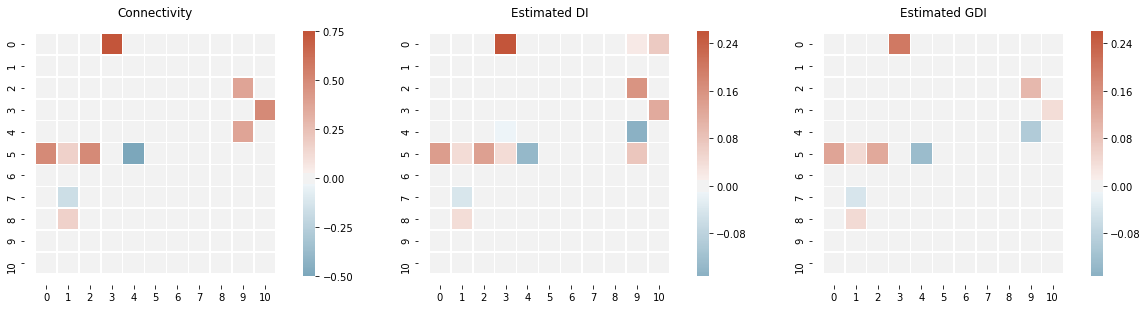

In [10]:
# Figure
f, ax = plt.subplots(figsize=(20, 9))

# Colormap
plt.subplot(131)
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Heatmap: True Connectivity
sns.heatmap(true_connectivity, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.xlim((-0.5, R+0.5))
plt.ylim((R+0.5,-0.5))
plt.title('Connectivity')

# Heatmap: DI
plt.subplot(132)
sns.heatmap(X_regular_sign*X_DI, cmap=cmap, 
            vmax=np.max(np.stack((X_regular_sign*X_DI,X_partial_sign*X_GDI))), 
            vmin = np.min(np.stack((X_regular_sign*X_DI,X_partial_sign*X_GDI))),  
            center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.xlim((-0.5, R+0.5))
plt.ylim((R+0.5,-0.5))
plt.title('Estimated DI')

# Heatmap: GDI
plt.subplot(133)
sns.heatmap(X_partial_sign*X_GDI, cmap=cmap, 
            vmax=np.max(np.stack((X_regular_sign*X_DI,X_partial_sign*X_GDI))), 
            vmin = np.min(np.stack((X_regular_sign*X_DI,X_partial_sign*X_GDI))),  
            center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.xlim((-0.5, R+0.5))
plt.ylim((R+0.5,-0.5))
plt.title('Estimated GDI');